In [1]:
!pip install -q "protobuf>=5.29.1,<6.0.0" requests==2.32.4 kaggle kagglesdk

In [ ]:
import os
!pip install -U -q kaggle
os.environ['KAGGLE_USERNAME'] = "YOUR_USERNAME"
os.environ['KAGGLE_API_TOKEN'] = "YOUR_PASSWORD"
!kaggle competitions download -c m5-forecasting-accuracy
!unzip -q -o m5-forecasting-accuracy.zip

 81% 37.0M/45.8M [00:00<00:00, 213MB/s] 
100% 45.8M/45.8M [00:00<00:00, 199MB/s]


In [2]:
import polars as pl
import os
#Cargamos los archivos
calendar = pl.scan_csv('calendar.csv').with_columns(pl.col("date").str.to_date("%Y-%m-%d"))
sell_prices = pl.scan_csv('sell_prices.csv')
sales_train = pl.scan_csv('sales_train_validation.csv')
os.chdir('/content/drive/MyDrive/WalmartM5')

### First, we examine the raw content of the tables.

In [ ]:
print(calendar.fetch(5))
print(sell_prices.fetch(5))
print(sales_train.fetch(5))

/tmp/ipython-input-781356399.py:1: DeprecationWarning: `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  print(calendar.fetch(5))


shape: (1_969, 14)
┌────────────┬──────────┬───────────┬──────┬───┬──────────────┬─────────┬─────────┬─────────┐
│ date       ┆ wm_yr_wk ┆ weekday   ┆ wday ┆ … ┆ event_type_2 ┆ snap_CA ┆ snap_TX ┆ snap_WI │
│ ---        ┆ ---      ┆ ---       ┆ ---  ┆   ┆ ---          ┆ ---     ┆ ---     ┆ ---     │
│ str        ┆ i64      ┆ str       ┆ i64  ┆   ┆ str          ┆ i64     ┆ i64     ┆ i64     │
╞════════════╪══════════╪═══════════╪══════╪═══╪══════════════╪═════════╪═════════╪═════════╡
│ 2011-01-29 ┆ 11101    ┆ Saturday  ┆ 1    ┆ … ┆ null         ┆ 0       ┆ 0       ┆ 0       │
│ 2011-01-30 ┆ 11101    ┆ Sunday    ┆ 2    ┆ … ┆ null         ┆ 0       ┆ 0       ┆ 0       │
│ 2011-01-31 ┆ 11101    ┆ Monday    ┆ 3    ┆ … ┆ null         ┆ 0       ┆ 0       ┆ 0       │
│ 2011-02-01 ┆ 11101    ┆ Tuesday   ┆ 4    ┆ … ┆ null         ┆ 1       ┆ 1       ┆ 0       │
│ 2011-02-02 ┆ 11101    ┆ Wednesday ┆ 5    ┆ … ┆ null         ┆ 1       ┆ 0       ┆ 1       │
│ …          ┆ …        ┆ …         ┆ …  

/tmp/ipython-input-781356399.py:2: DeprecationWarning: `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  print(sell_prices.fetch(5))


shape: (6_841_121, 4)
┌──────────┬───────────────┬──────────┬────────────┐
│ store_id ┆ item_id       ┆ wm_yr_wk ┆ sell_price │
│ ---      ┆ ---           ┆ ---      ┆ ---        │
│ str      ┆ str           ┆ i64      ┆ f64        │
╞══════════╪═══════════════╪══════════╪════════════╡
│ CA_1     ┆ HOBBIES_1_001 ┆ 11325    ┆ 9.58       │
│ CA_1     ┆ HOBBIES_1_001 ┆ 11326    ┆ 9.58       │
│ CA_1     ┆ HOBBIES_1_001 ┆ 11327    ┆ 8.26       │
│ CA_1     ┆ HOBBIES_1_001 ┆ 11328    ┆ 8.26       │
│ CA_1     ┆ HOBBIES_1_001 ┆ 11329    ┆ 8.26       │
│ …        ┆ …             ┆ …        ┆ …          │
│ WI_3     ┆ FOODS_3_827   ┆ 11617    ┆ 1.0        │
│ WI_3     ┆ FOODS_3_827   ┆ 11618    ┆ 1.0        │
│ WI_3     ┆ FOODS_3_827   ┆ 11619    ┆ 1.0        │
│ WI_3     ┆ FOODS_3_827   ┆ 11620    ┆ 1.0        │
│ WI_3     ┆ FOODS_3_827   ┆ 11621    ┆ 1.0        │
└──────────┴───────────────┴──────────┴────────────┘


/tmp/ipython-input-781356399.py:3: DeprecationWarning: `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  print(sales_train.fetch(5))


shape: (30_490, 1_919)
┌────────────────────┬───────────────┬───────────┬─────────┬───┬────────┬────────┬────────┬────────┐
│ id                 ┆ item_id       ┆ dept_id   ┆ cat_id  ┆ … ┆ d_1910 ┆ d_1911 ┆ d_1912 ┆ d_1913 │
│ ---                ┆ ---           ┆ ---       ┆ ---     ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ str                ┆ str           ┆ str       ┆ str     ┆   ┆ i64    ┆ i64    ┆ i64    ┆ i64    │
╞════════════════════╪═══════════════╪═══════════╪═════════╪═══╪════════╪════════╪════════╪════════╡
│ HOBBIES_1_001_CA_1 ┆ HOBBIES_1_001 ┆ HOBBIES_1 ┆ HOBBIES ┆ … ┆ 3      ┆ 0      ┆ 1      ┆ 1      │
│ _validation        ┆               ┆           ┆         ┆   ┆        ┆        ┆        ┆        │
│ HOBBIES_1_002_CA_1 ┆ HOBBIES_1_002 ┆ HOBBIES_1 ┆ HOBBIES ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ _validation        ┆               ┆           ┆         ┆   ┆        ┆        ┆        ┆        │
│ HOBBIES_1_003_CA_1 ┆ HOBBIES_1_003 ┆ HOBBIES_1 ┆ HOBBIES ┆ … ┆ 0  

###We analyse the distribution of sales, to conclude that the vast majority of them are zero. This suggests that we are dealing with a sparse dataset.

/tmp/ipython-input-1919123779.py:5: DeprecationWarning: `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  .fetch(1000)


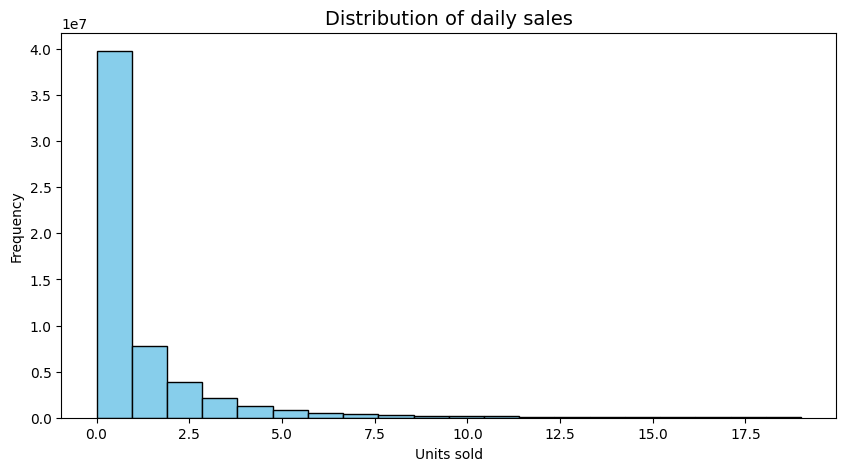

In [3]:
import matplotlib.pyplot as plt

sample_values = (
    sales_train
    .fetch(1000)
    .select(pl.col(r"^d_\d+$"))
    .unpivot()
    .filter(pl.col("value") < 20)
)

plt.figure(figsize=(10, 5))
plt.hist(sample_values["value"], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of daily sales", fontsize=14)
plt.xlabel("Units sold")
plt.ylabel("Frequency")
plt.show()

In [4]:
calendar = (
    pl.scan_csv("calendar.csv")
    .select(["d", "date", "wm_yr_wk", "event_name_1"])
    .with_columns(
        pl.col("date").str.to_date("%Y-%m-%d")
    )
)

# We unpivot to work with long format
id_cols = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
cols_unpivot = {f"d_{i}": pl.Int16 for i in range(1, 1914)}
sales_long = (
    sales_train
    .with_columns([
        pl.col(c).cast(pl.Categorical) for c in id_cols
    ])
    .unpivot(
        index=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        on=pl.col(r"^d_\d+$"),
        variable_name="d",
        value_name="sales"
    )
    .join(calendar, on="d", how="left")
    .with_columns(
        pl.col("date"),
        pl.col("sales")
    )
)

### Let's plot the sales for a certain product in a certain store.

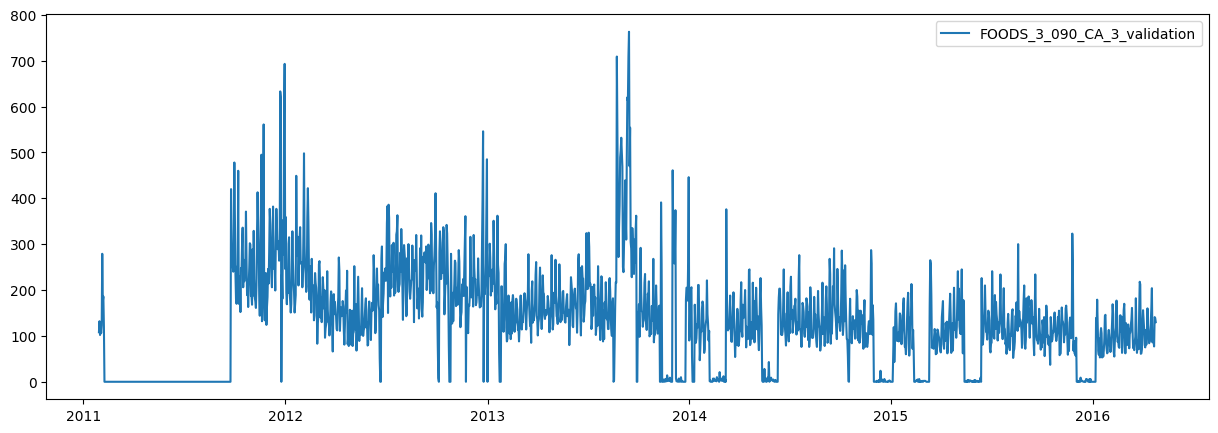

In [10]:
import matplotlib.pyplot as plt

item_id_target = "FOODS_3_090_CA_3_validation"
df_hobbies = (
    sales_long
    .filter(pl.col("id") == item_id_target)
    .select(["date", "sales", "d"])
)
df_single = df_hobbies.collect()

plt.figure(figsize=(15,5))
plt.plot(df_single["date"], df_single["sales"], label = item_id_target)
plt.legend()
plt.show()


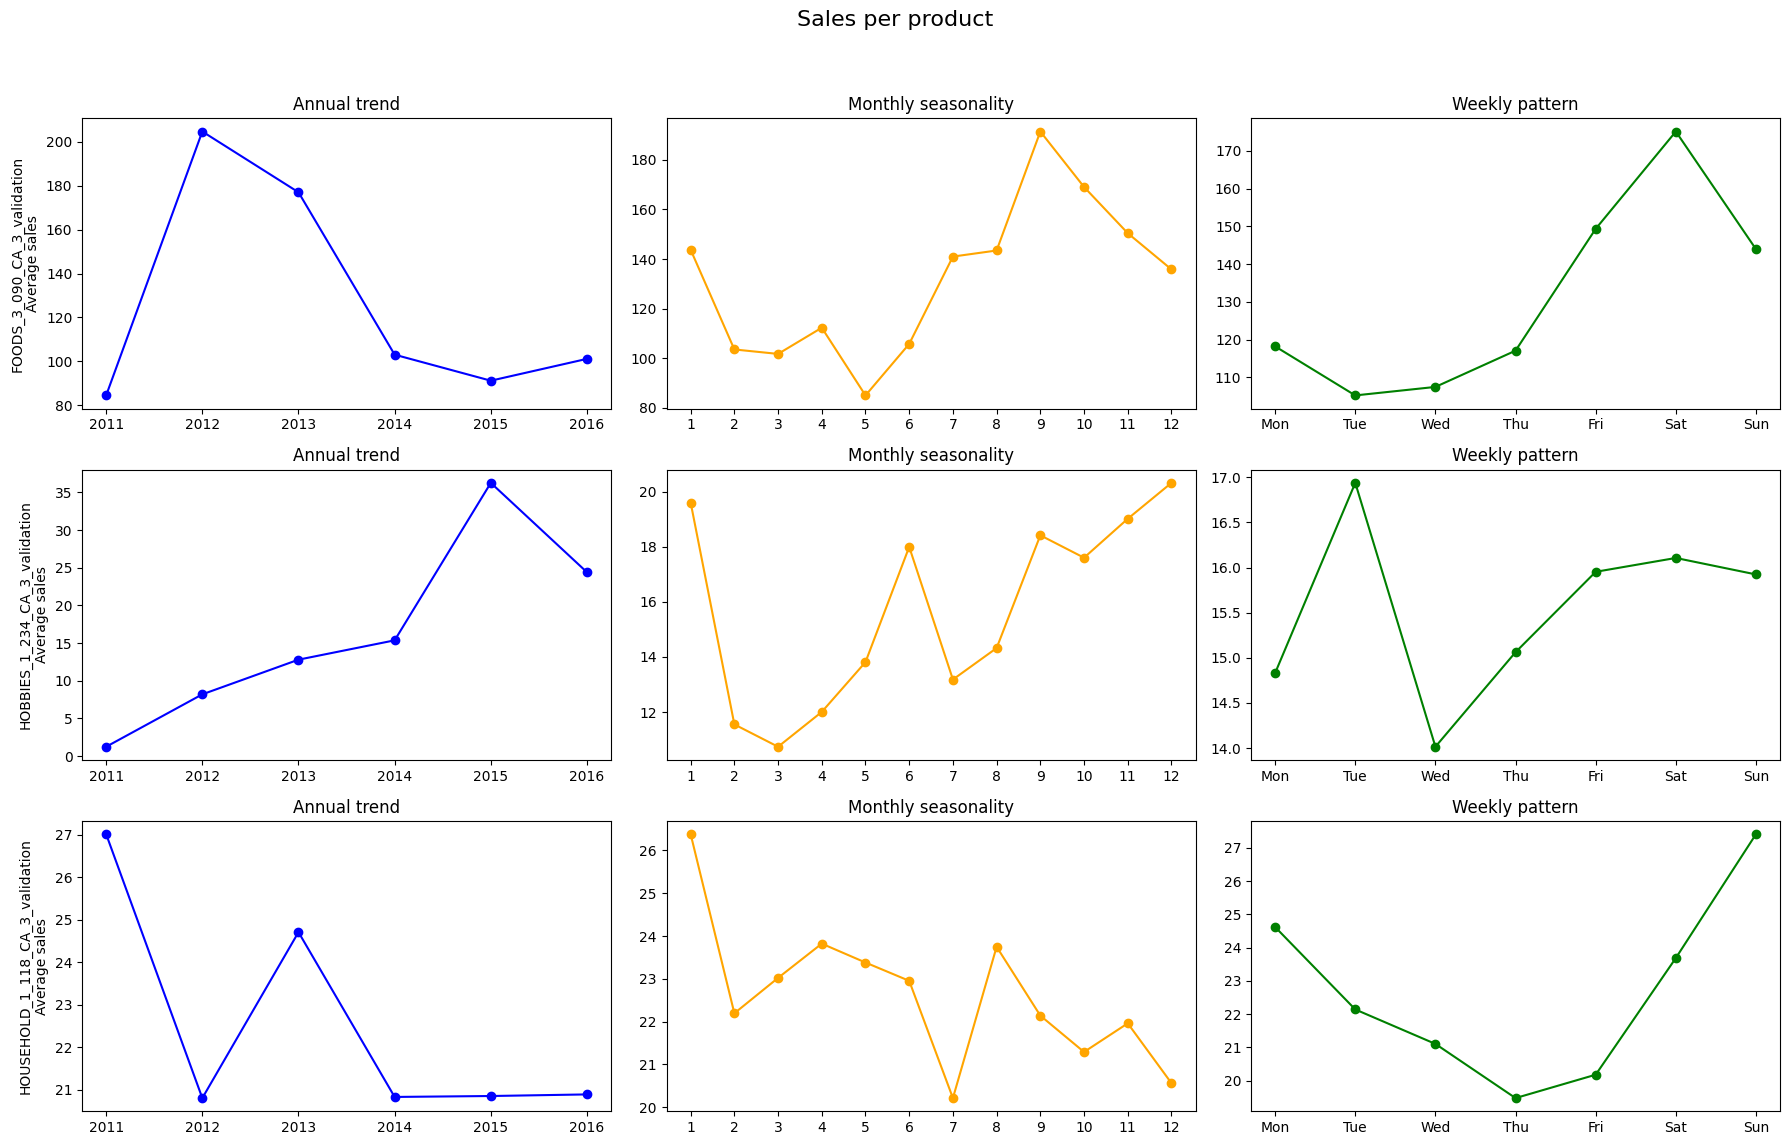

In [5]:

raw_examples = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
examples = [f"{x}_validation" for x in raw_examples]

df_foods = (
    sales_long
    .filter(pl.col("id").is_in(examples))
    .select(["id", "date", "sales"])
    .with_columns([
        pl.col("date").dt.year().alias("year"),
        pl.col("date").dt.month().alias("month"),
        pl.col("date").dt.weekday().alias("wday"),
    ])
    .collect()
)

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Sales per product", fontsize=16)

for i, item in enumerate(examples):

    current_item_df = df_foods.filter(pl.col("id") == item)

    agg_year = (
        current_item_df.group_by("year")
        .agg(pl.col("sales").mean())
        .sort("year")
    )
    axs[i, 0].plot(agg_year["year"], agg_year["sales"], marker='o', color='blue')
    axs[i, 0].set_ylabel(f"{item}\nAverage sales")
    axs[i, 0].set_title(f"Annual trend")

    agg_month = (
        current_item_df.group_by("month")
        .agg(pl.col("sales").mean())
        .sort("month")
    )
    axs[i, 1].plot(agg_month["month"], agg_month["sales"], marker='o', color='orange')
    axs[i, 1].set_title(f"Monthly seasonality")
    axs[i, 1].set_xticks(range(1, 13))

    agg_wday = (
        current_item_df.group_by("wday")
        .agg(pl.col("sales").mean())
        .sort("wday")
    )
    axs[i, 2].plot(agg_wday["wday"], agg_wday["sales"], marker='o', color='green')
    axs[i, 2].set_title(f"Weekly pattern")
    axs[i, 2].set_xticks(range(1, 8))
    axs[i, 2].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Now more products

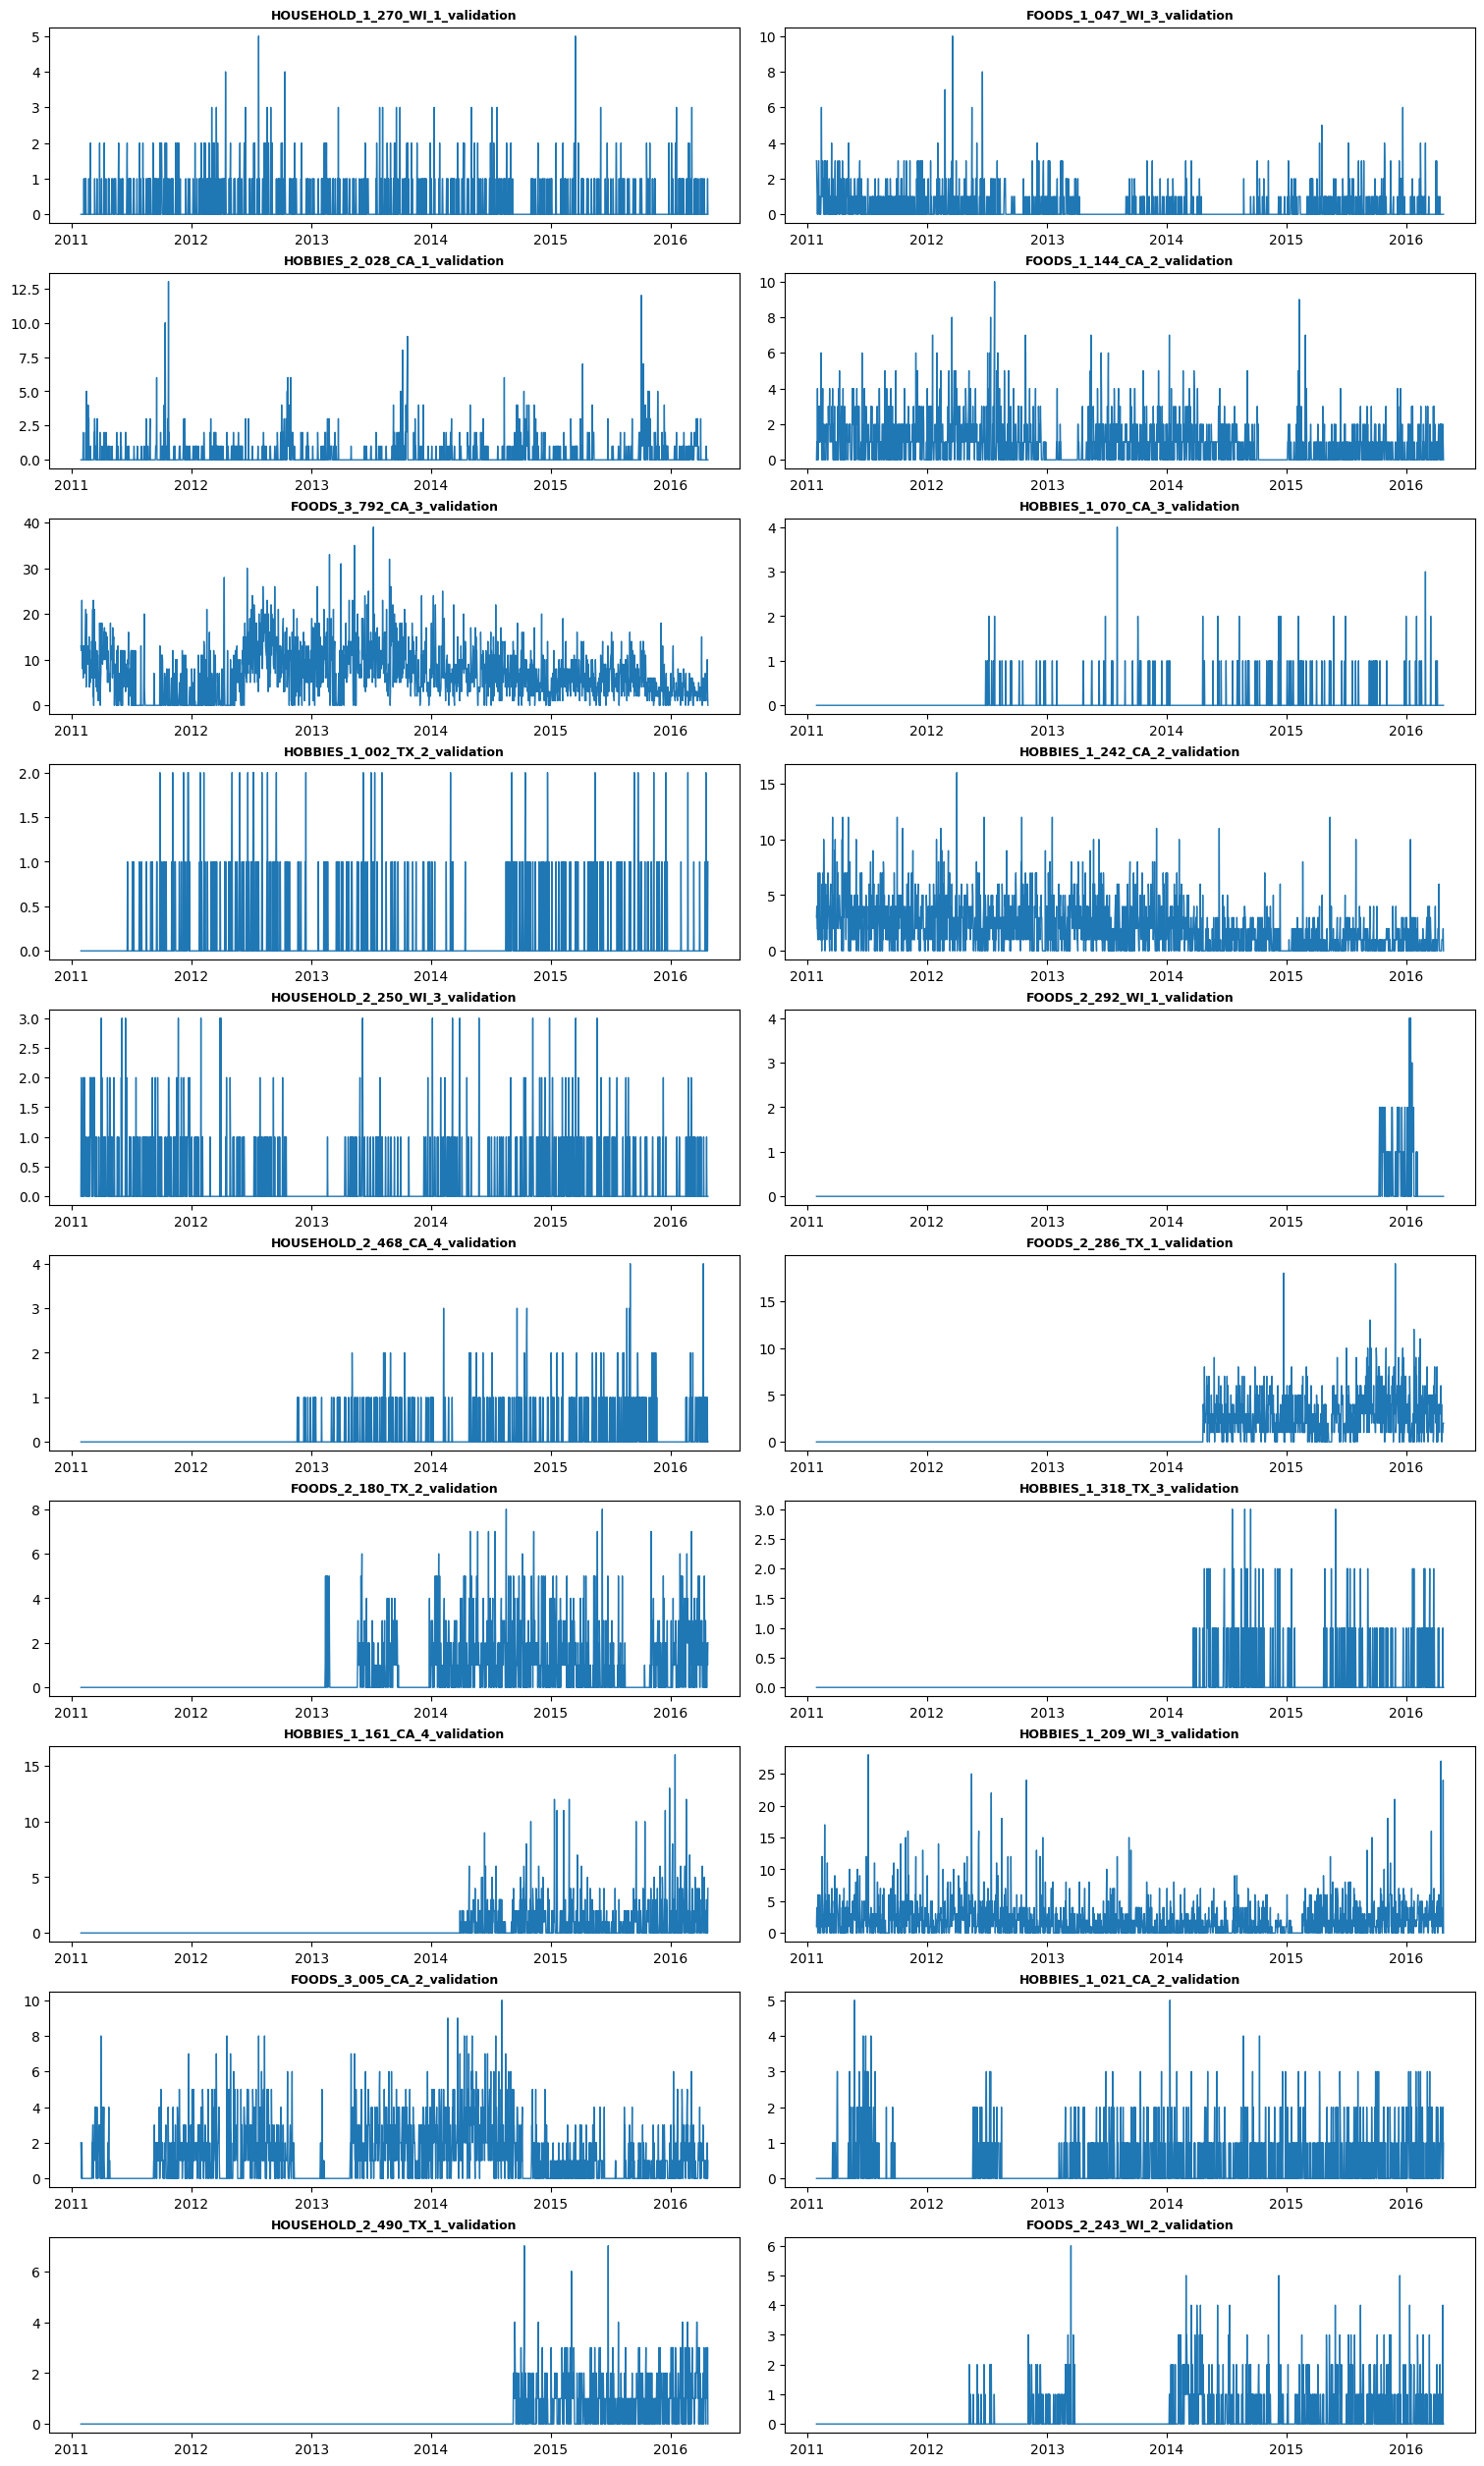

In [12]:
all_ids = sales_long.select("id").unique().collect()
sampled_ids = all_ids.sample(n=20, seed=529)["id"].to_list()
fig, axs = plt.subplots(10, 2, figsize=(15, 25), constrained_layout=True)
axs = axs.flatten()

for i, item_id in enumerate(sampled_ids):
    item_data = (
        sales_long.filter(pl.col("id") == item_id)
        .sort("date")
        .collect()
    )
    axs[i].plot(item_data["date"], item_data["sales"], linewidth=1)
    axs[i].set_title(item_id, fontsize=9, fontweight='bold')
    axs[i].tick_params(axis='x', rotation=0)

plt.show()

### We check the distribution of item categories.

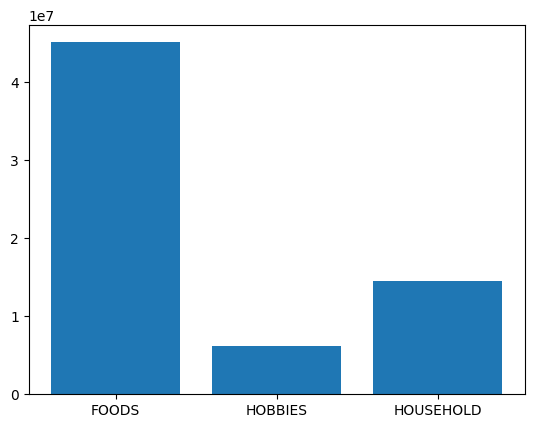

In [ ]:

df_cat = (
    sales_long
    .select(["cat_id", "sales"])
    .group_by(pl.col("cat_id"))
    .agg(pl.col("sales").sum())
    .collect()
)

plt.bar(df_cat["cat_id"], df_cat["sales"])
plt.show()

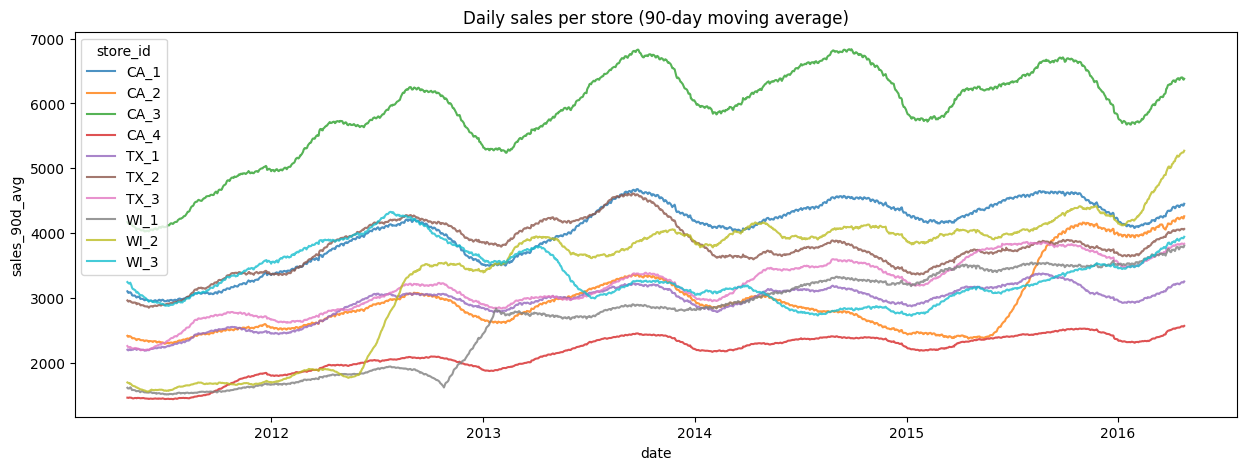

In [6]:
import seaborn as sns

df_store = (
    sales_long
    .group_by(["date", "store_id"])
    .agg(pl.col("sales").sum())
    .sort("date")
    .with_columns(
        pl.col("sales")
        .rolling_mean(window_size=90)
        .over("store_id")
        .alias("sales_90d_avg")
    )
    .collect()
)

plt.figure(figsize=(15, 5))

sns.lineplot(
    data=df_store,
    x="date",
    y="sales_90d_avg",
    hue="store_id",
    alpha=0.8
)

plt.title("Daily sales per store (90-day moving average)")
plt.show()

### The main insights we get are:

### 1. Sparsity. The daily sales distribution is heavily zero-inflated. We will strictly use Tweedie Loss (p=1.1) in our LightGBM models, as it effectively handles the point mass at zero inherent in Poisson-Gamma distributions.

### 2. Weekly seasonality is dominant. The spectral analysis of sales clearly shows that the weekly cycle (peaks on weekends) is the strongest signal, overpowering monthly or annual trends. Our feature engineering must prioritize Modulo-7 lags (7, 14, 28 days) and rolling statistics with 7-day shifts to capture this heartbeat.

### 3. Heterogeneity across Stores. While the macro trend is similar, the volatility and volume vary significantly between stores. A single global model would underfit. We will train separate LightGBM estimators for each store to capture specific local dynamics while maintaining computational efficiency using Polars.